## Model Evaluation

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score

In [2]:
loan_df = pd.read_csv(r'C:\Users\Joseph\OneDrive\Documents\CFI\Loan Default Prediction With Machine Learning\data\new_data\data\vehicle_loans_feat_1.csv', index_col='UNIQUEID')

In [6]:
# build the logistic regression model

category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

In [8]:
small_cols = ['STATE_ID', 'LTV', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE', 'LOAN_DEFAULT']
loan_df_sml = loan_df[small_cols]

loan_data_dumm = pd.get_dummies(loan_df_sml, prefix_sep='_', drop_first=True)

x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
y = loan_data_dumm['LOAN_DEFAULT']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(x_train, y_train)

LogisticRegression(max_iter=200)

In [9]:
logistic_model.score(x_test, y_test)

0.7822264159035834

### Confusion Matrix

In [10]:
# let's create the confusion matrix using predict to extract the model's prediction on the test data

preds = logistic_model.predict(x_test)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
conf_mat = confusion_matrix(y_test, preds)
conf_mat

array([[36476,     1],
       [10154,     0]], dtype=int64)

The confusion matrix returns a 2D array of TN, FP, FN, and TP

In this case, it's a table with rows and columns, which we can access elements as [row_idx][col_idx]. let's extract TN and FP from  the confusion matrix.

In [12]:
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]

In [13]:
print("True Negatives (Correct Non-Defaults): ", tn)
print("False Positives (Incorrect Defaults): ", fp)
print("False Negatives (Incorrect Non-Defaults): ", fn)
print("True Positives (Correct Defaults)", tp)

True Negatives (Correct Non-Defaults):  36476
False Positives (Incorrect Defaults):  1
False Negatives (Incorrect Non-Defaults):  10154
True Positives (Correct Defaults) 0


Now, the 78% accuracy makes a bit more sense, the model is pretty much predicting all loans as non-defaults. This indicates that accuracy alone is not a reliable indicator of model performance. Let's explore some other measures of performance.

### Precision = TP/(TP + FP)

In [14]:
precision = precision_score(y_test, preds)
precision

0.0

### Recall = TP/(TP + FN)

In [15]:
recall = recall_score(y_test, preds)
recall

0.0

### ROC Curve

In [16]:
probs = logistic_model.predict_proba(x_test)
probs

array([[0.73726194, 0.26273806],
       [0.79731094, 0.20268906],
       [0.78858117, 0.21141883],
       ...,
       [0.79720592, 0.20279408],
       [0.88808912, 0.11191088],
       [0.77018079, 0.22981921]])

In [17]:
probs.shape

(46631, 2)

In [18]:
print(probs[:, 0])
print(probs[:, 1])

[0.73726194 0.79731094 0.78858117 ... 0.79720592 0.88808912 0.77018079]
[0.26273806 0.20268906 0.21141883 ... 0.20279408 0.11191088 0.22981921]


In [19]:
probs_df = pd.DataFrame()
probs_df['prob_0'] = probs[:, 0]
probs_df['prob_1'] = probs[:, 1]

probs_df.describe()

,prob_0,prob_1
count,46631.000000,46631.000000
mean,0.783635,0.216365
std,0.064450,0.064450
min,0.497261,0.037131
25%,0.742114,0.172254
50%,0.785731,0.214269
75%,0.827746,0.257886
max,0.962869,0.502739


In [20]:
fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)

In [21]:
print("FPR: ", fpr)
print("TPR: ", tpr)
print("Threshold: ", threshold)

FPR:  [0.00000000e+00 2.74145352e-05 2.74145352e-05 ... 9.99780684e-01
 9.99780684e-01 1.00000000e+00]
TPR:  [0.00000000e+00 0.00000000e+00 9.84833563e-05 ... 9.99901517e-01
 1.00000000e+00 1.00000000e+00]
Threshold:  [1.50273935 0.50273935 0.48553074 ... 0.05182349 0.05173471 0.03713136]


In [22]:
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['threshold'] = threshold

roc_df.describe()

,fpr,tpr,threshold
count,17427.000000,17427.000000,17427.000000
mean,0.422021,0.530551,0.228609
std,0.275369,0.285370,0.063513
min,0.000000,0.000000,0.037131
25%,0.183705,0.289640,0.187158
50%,0.396195,0.541363,0.225622
75%,0.639554,0.777822,0.267425
max,1.000000,1.000000,1.502739


In [23]:
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

AUC:  0.6062342275639365


Our model has an AUC of ~0.61

- The AUC score for a random classifier is 0.5
- Our model is not doing a good job of separating the classes

In [24]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

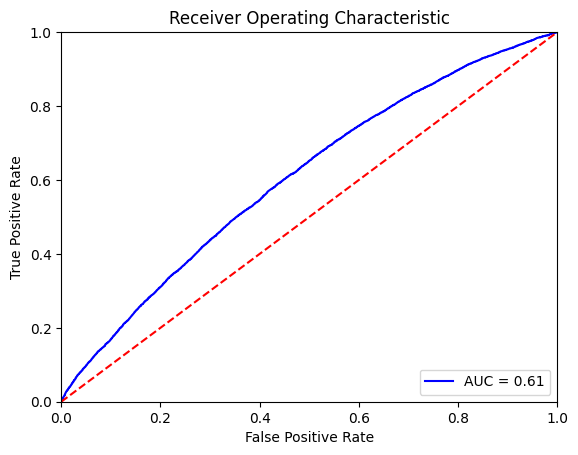

In [25]:
plot_roc_curve(fpr, tpr, roc_auc)